## 1. IMPORTING LIBRARIES & LOADING DATA

In [705]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from IPython.display import display
from scipy.stats import chi2_contingency, ttest_ind


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visual style to match the sample
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully.")

Libraries imported successfully.


In [706]:
# Load the dataset
try:
    df = pd.read_csv('data/Telco-Customer-Churn.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("CSV not found. Place it in 'data/' or adjust the path.")


# Copy of raw data (useful for comparison)
df_raw = df.copy()


Dataset loaded successfully.


## 2. DATASET ANALYSIS

In [707]:
# Display first 5 rows
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [708]:
# Check data shape (Rows, Columns)
print(f"\nShape of dataset: {df.shape}")


Shape of dataset: (7043, 21)


In [709]:
# Check data types and existing nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [710]:
print("\nSummary statistics for numeric columns:")
print(df.describe())


Summary statistics for numeric columns:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [711]:
# Check for duplicates
dup_count = df.duplicated().sum()
print(f"\nDuplicate Rows: {dup_count}")



Duplicate Rows: 0


In [712]:
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 3. DATA CLEANING

In [713]:
# Replace blank strings with NaN
df = df.replace(r"^\s*$", np.nan, regex=True)

In [714]:
# Convert TotalCharges to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    missing_tc = df["TotalCharges"].isna().sum()
    print(f"Missing values in TotalCharges after conversion: {missing_tc}")

Missing values in TotalCharges after conversion: 11


In [715]:
# Impute missing TotalCharges
if "TotalCharges" in df.columns:
    median_tc = df["TotalCharges"].median()
    df["TotalCharges"].fillna(median_tc, inplace=True)
    print(f"Imputed missing TotalCharges with median = {median_tc:.2f}")

Imputed missing TotalCharges with median = 1397.47


In [716]:
# Remove non-informative identifier
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)
    print("Dropped 'customerID' column.")

Dropped 'customerID' column.


In [717]:
# Binary Yes/No columns to 0/1
binary_map = {"Yes": 1, "No": 0}
for col in df.columns:
    # Only map if column contains subset of Yes/No (ignoring NaNs)
    unique_vals = set(df[col].dropna().unique())
    if unique_vals and unique_vals <= {"Yes", "No"}:
        df[col] = df[col].map(binary_map)

In [718]:
# Ensure Churn is clearly numeric 0/1
if "Churn" in df.columns:
    if df["Churn"].dtype == "O":
        df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
    df["Churn"] = df["Churn"].astype(int)

In [719]:
print("\n CLEANED DATA (first 5 rows) ")
display(df.head())

print("\nMissing values after cleaning:")
print(df.isna().sum())


 CLEANED DATA (first 5 rows) 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1



Missing values after cleaning:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 4. EXPLORATORY DATA ANALYSIS

##### Univariate Distributions

In [720]:
# Statistical Summary of Numerical Columns
print("Statistical Summary (Numerical)")
display(df.describe())

Statistical Summary (Numerical)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2281.916928,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2265.270398,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,402.225000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [721]:
# Statistical Summary of Categorical Columns
print("\nStatistical Summary (Categorical)")
display(df.describe(include=['O']))


Statistical Summary (Categorical)


,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,3,3,3,3,3,3,3,3,3,4
top,Male,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check
freq,3555,3390,3096,3498,3088,3095,3473,2810,2785,3875,2365


In [722]:
# Check Unique Values for key categorical columns
# This helps us identify if there are any typos like "Yes" vs "yes"
print("\nUnique Values in 'PaymentMethod'")
print(df['PaymentMethod'].unique())

print("\nUnique Values in 'Contract'")
print(df['Contract'].unique())


Unique Values in 'PaymentMethod'
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Unique Values in 'Contract'
['Month-to-month' 'One year' 'Two year']



Churn Count (Target):
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn Percentage:
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


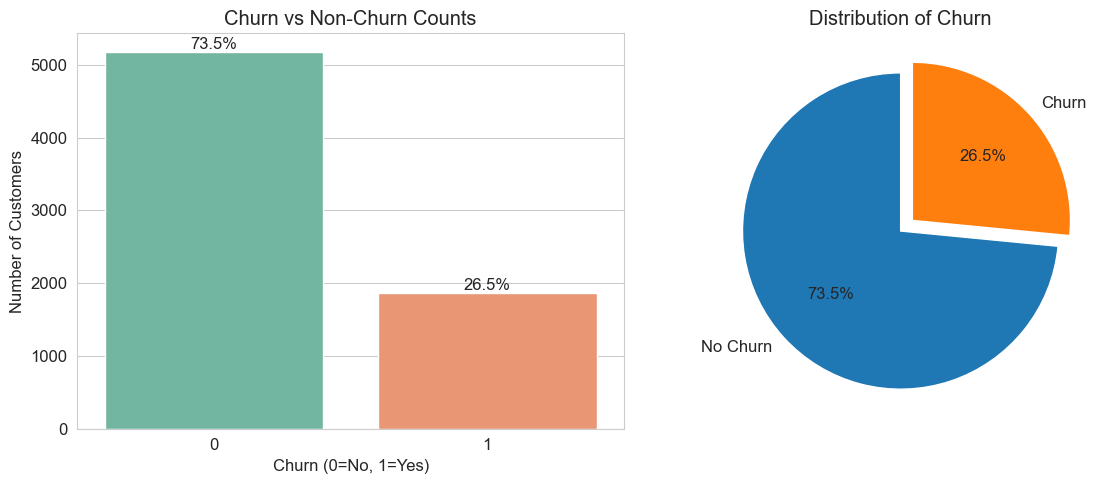

In [723]:
# Target Variable – Churn
if "Churn" in df.columns:
    print("\nChurn Count (Target):")
    print(df["Churn"].value_counts())

    print("\nChurn Percentage:")
    print((df["Churn"].value_counts(normalize=True) * 100).round(2))

    churn_counts = df["Churn"].value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.countplot(data=df, x="Churn", ax=axes[0], palette="Set2")
    axes[0].set_title("Churn vs Non-Churn Counts")
    axes[0].set_xlabel("Churn (0=No, 1=Yes)")
    axes[0].set_ylabel("Number of Customers")

    total = len(df)
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].annotate(
            f"{100 * height / total:.1f}%",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom",
        )

    axes[1].pie(
        churn_counts,
        labels=["No Churn", "Churn"],  # assumes value_counts sorted 0,1
        autopct="%1.1f%%",
        startangle=90,
        explode=(0, 0.1),
    )
    axes[1].set_title("Distribution of Churn")

    plt.tight_layout()
    plt.show()

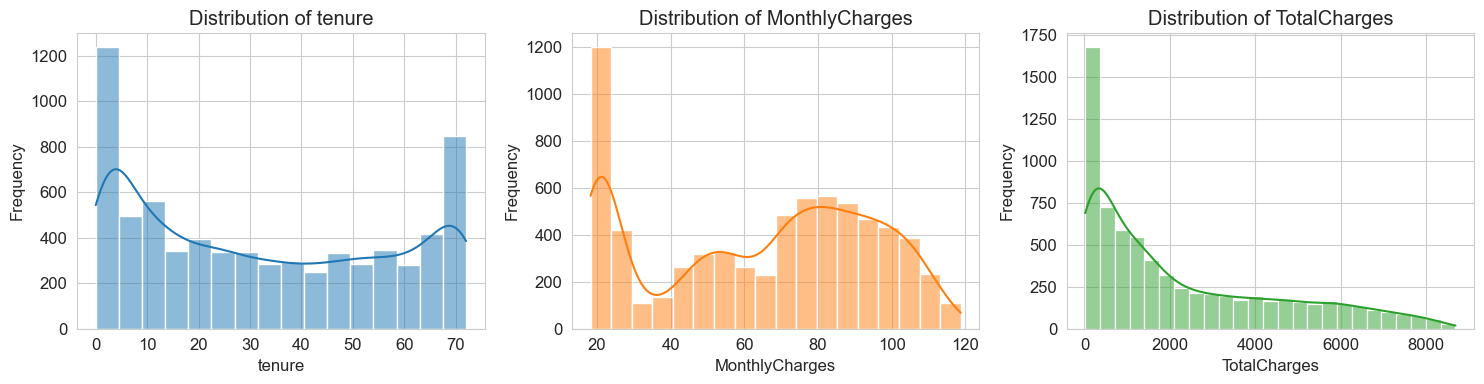

In [724]:
# Numeric feature distributions
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
numeric_cols = [c for c in numeric_cols if c in df.columns]

if numeric_cols:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(5 * len(numeric_cols), 4))
    if len(numeric_cols) == 1:
        axes = [axes]

    for ax, col, color in zip(axes, numeric_cols, colors):
        sns.histplot(df[col].dropna(), kde=True, ax=ax, color=color)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()



#### - `tenure` is skewed towards newer customers.
#### - `MonthlyCharges` shows a spread with higher-paying customers.
#### - `TotalCharges` is skewed and linked to tenure and monthly charges.

Categorical columns (for distribution plots): ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


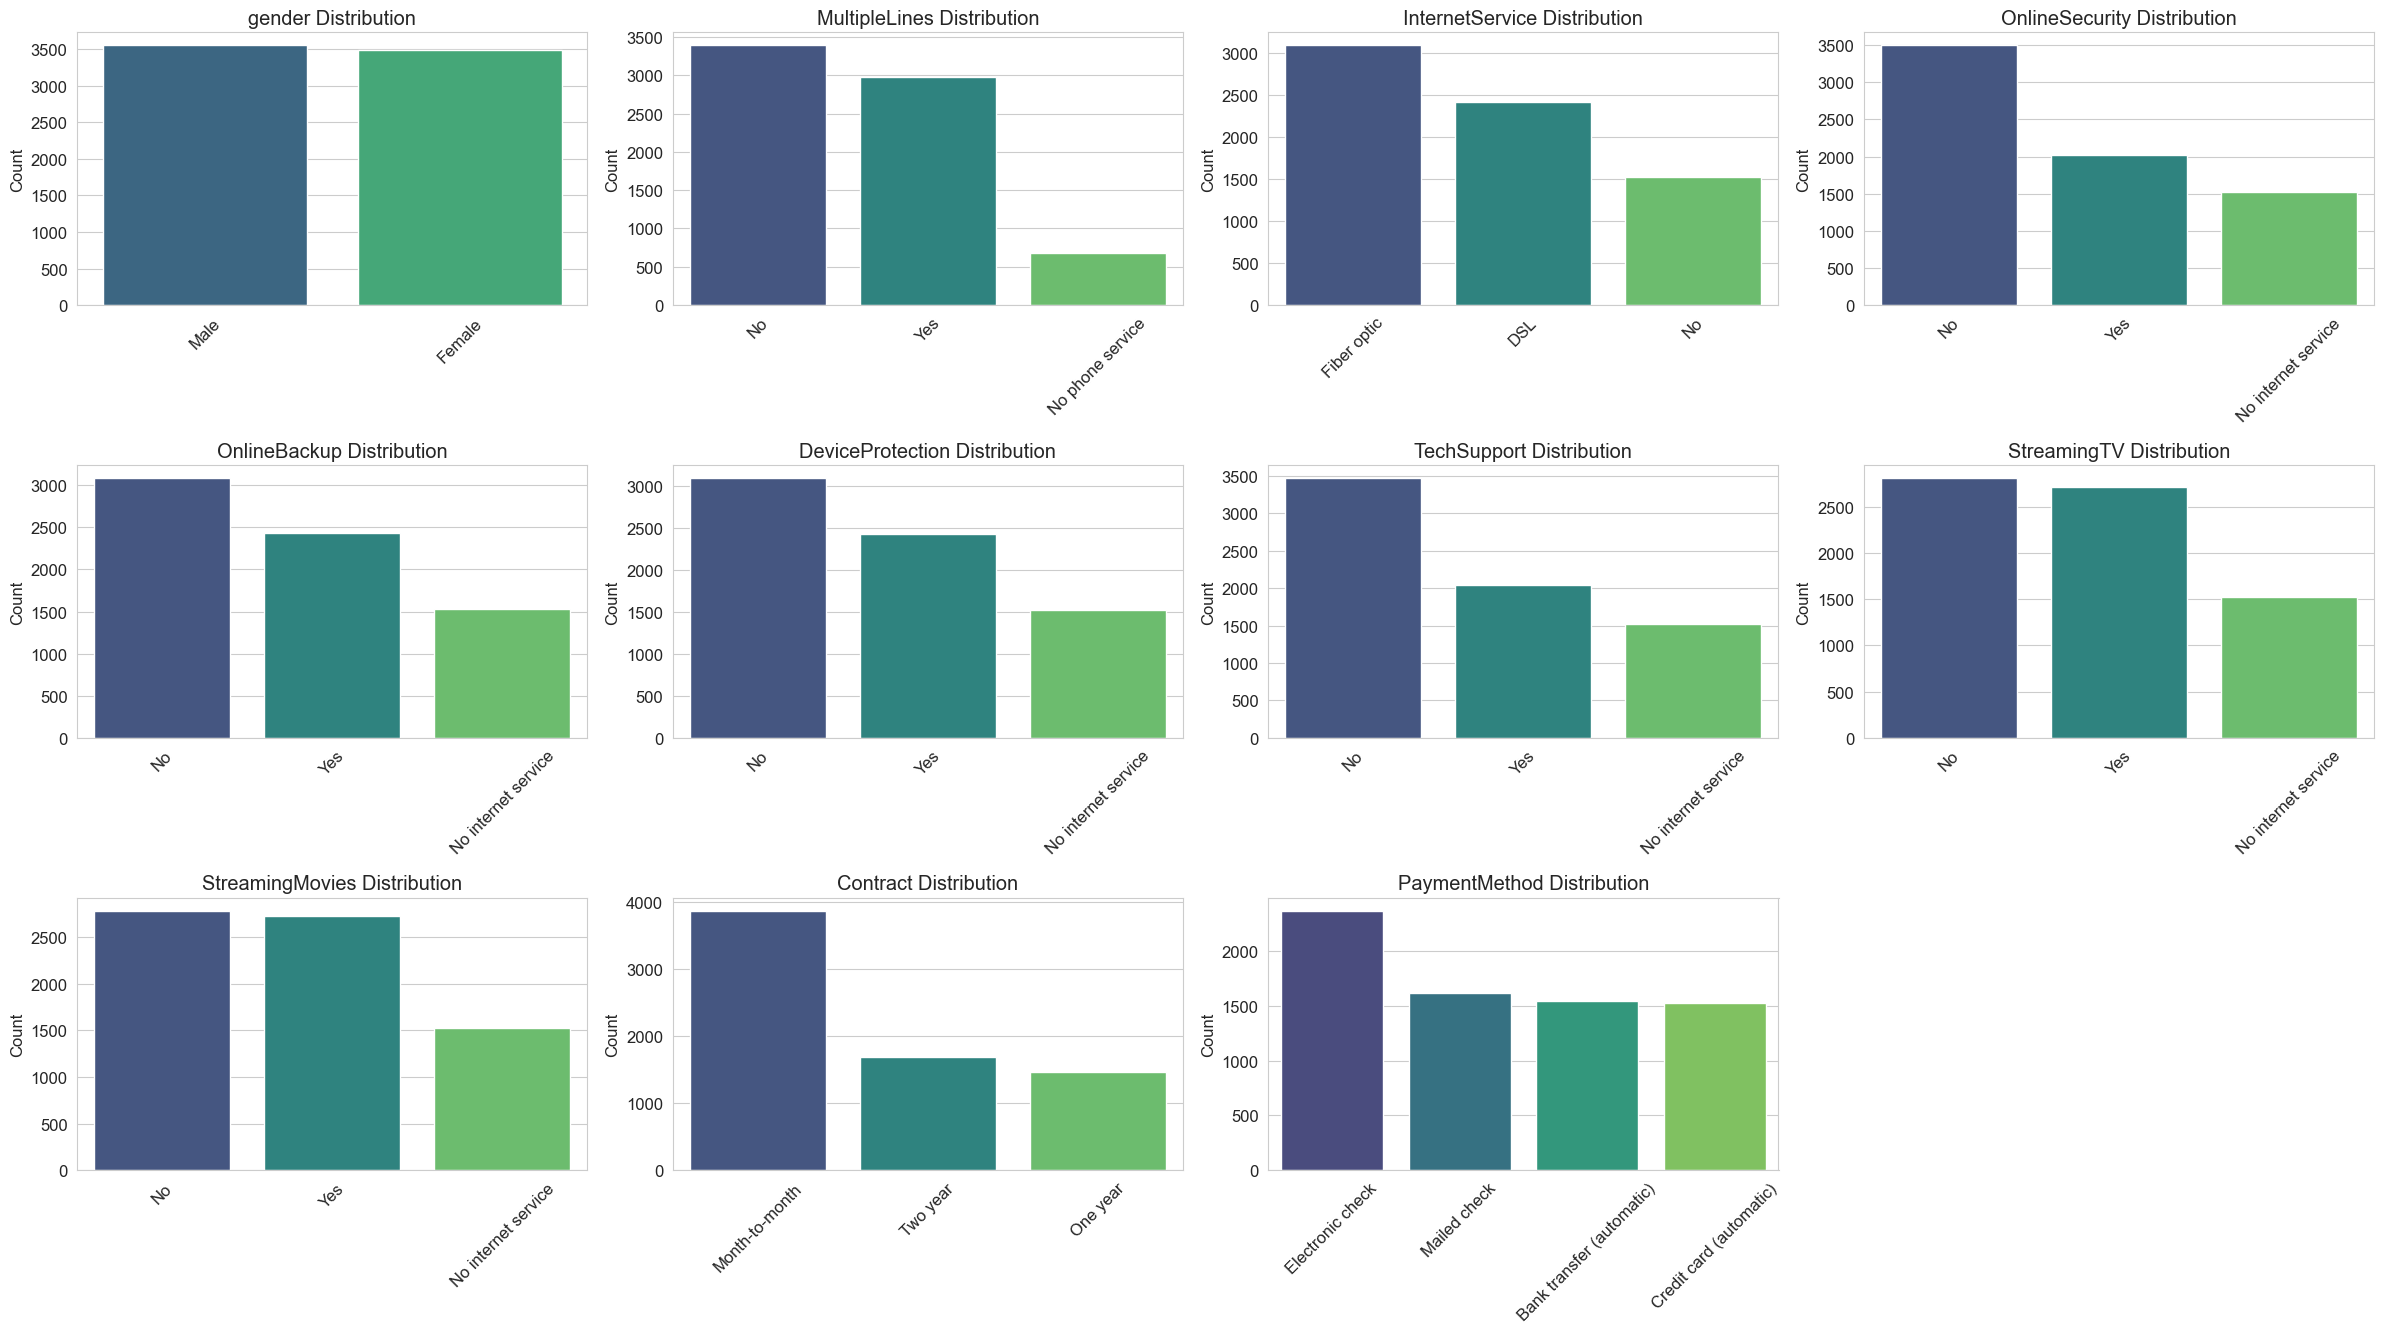

In [725]:
# Categorical feature distributions

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Exclude target and identifier – we do NOT want plots for IDs
cat_cols = [c for c in cat_cols if c not in ["Churn", "customerID"]]

print("Categorical columns (for distribution plots):", cat_cols)

n_cols = 4  # number of subplots per row
n_features = len(cat_cols)
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # Safety: skip if column somehow missing
    if col not in df.columns:
        continue

    ax = axes[i]
    order = df[col].value_counts().index
    
    sns.countplot(
        x=col,
        data=df,
        order=order,
        palette="viridis",
        ax=ax
    )
    
    ax.set_title(f"{col} Distribution")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

# Remove empty subplots if the grid is not full
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


##### Bivariate Analysis

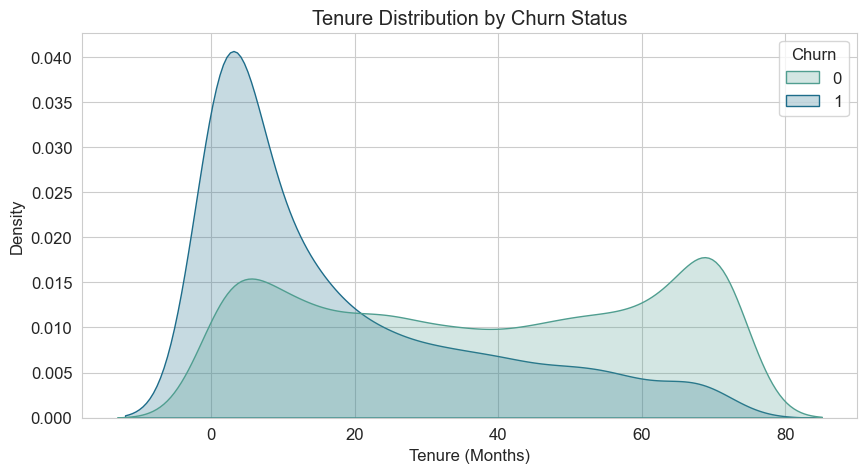

In [726]:
# Tenure vs Churn (KDE)
if {"tenure", "Churn"} <= set(df.columns):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=df,
        x="tenure",
        hue="Churn",
        fill=True,
        palette="crest",
        common_norm=False,
    )
    plt.title("Tenure Distribution by Churn Status")
    plt.xlabel("Tenure (Months)")
    plt.ylabel("Density")
    plt.show()

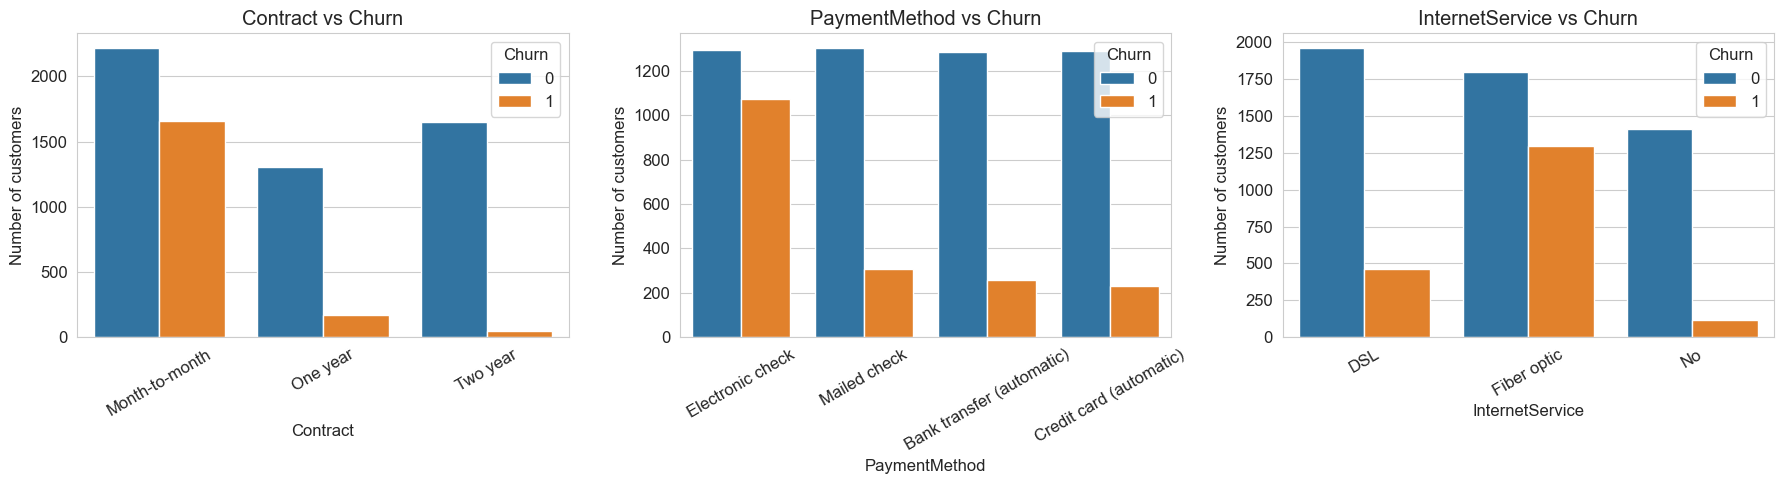


Mean values of key numerical features by Churn status:


,tenure,MonthlyCharges,TotalCharges
Churn,,,
0,37.57,61.27,2552.88
1,17.98,74.44,1531.80


In [727]:
# Numeric features vs Churn

important_cats = ["Contract", "PaymentMethod", "InternetService"]
important_cats = [c for c in important_cats if c in df.columns]

if important_cats:
    fig, axes = plt.subplots(1, len(important_cats), figsize=(6 * len(important_cats), 5))
    if len(important_cats) == 1:
        axes = [axes]

    for ax, col in zip(axes, important_cats):
        sns.countplot(data=df, x=col, hue="Churn", ax=ax)
        ax.set_title(f"{col} vs Churn")
        ax.set_xlabel(col)
        ax.set_ylabel("Number of customers")
        ax.tick_params(axis="x", rotation=30)

    plt.tight_layout()
    plt.show()

# Numeric means by Churn
if {"Churn"} <= set(df.columns):
    num_for_mean = [c for c in ["tenure", "MonthlyCharges", "TotalCharges"] if c in df.columns]
    if num_for_mean:
        print("\nMean values of key numerical features by Churn status:")
        display(
            df.groupby("Churn")[num_for_mean]
              .mean()
              .round(2)
        )



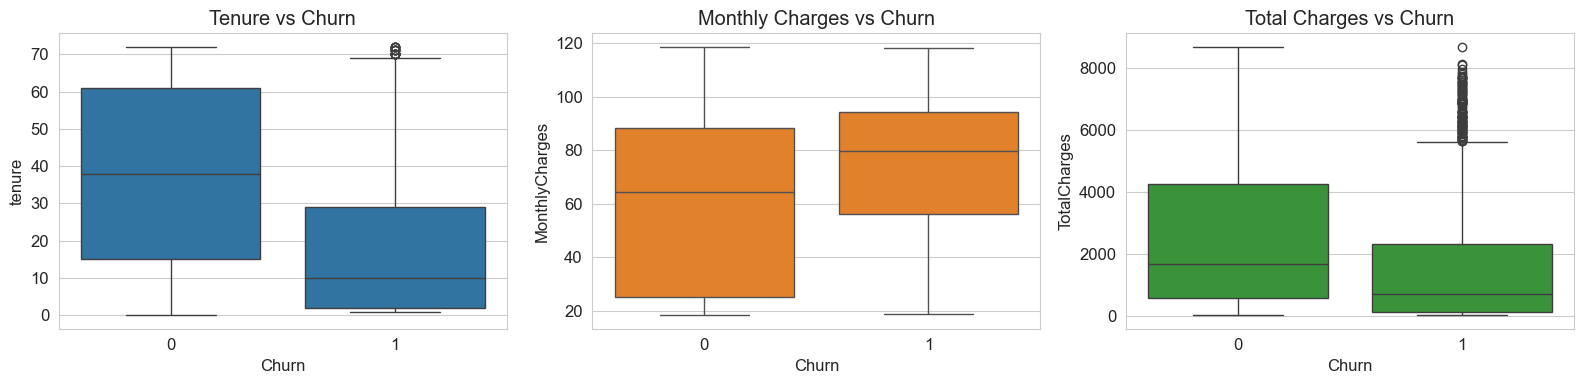

In [728]:
# Boxplots vs Churn
if all(c in df.columns for c in ["Churn", "tenure", "MonthlyCharges", "TotalCharges"]):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    sns.boxplot(x="Churn", y="tenure", data=df, ax=axes[0], palette=[colors[0], colors[0]])
    axes[0].set_title("Tenure vs Churn")

    sns.boxplot(
        x="Churn", y="MonthlyCharges", data=df, ax=axes[1], palette=[colors[1], colors[1]]
    )
    axes[1].set_title("Monthly Charges vs Churn")

    sns.boxplot(
        x="Churn", y="TotalCharges", data=df, ax=axes[2], palette=[colors[2], colors[2]]
    )
    axes[2].set_title("Total Charges vs Churn")

    plt.tight_layout()
    plt.show()



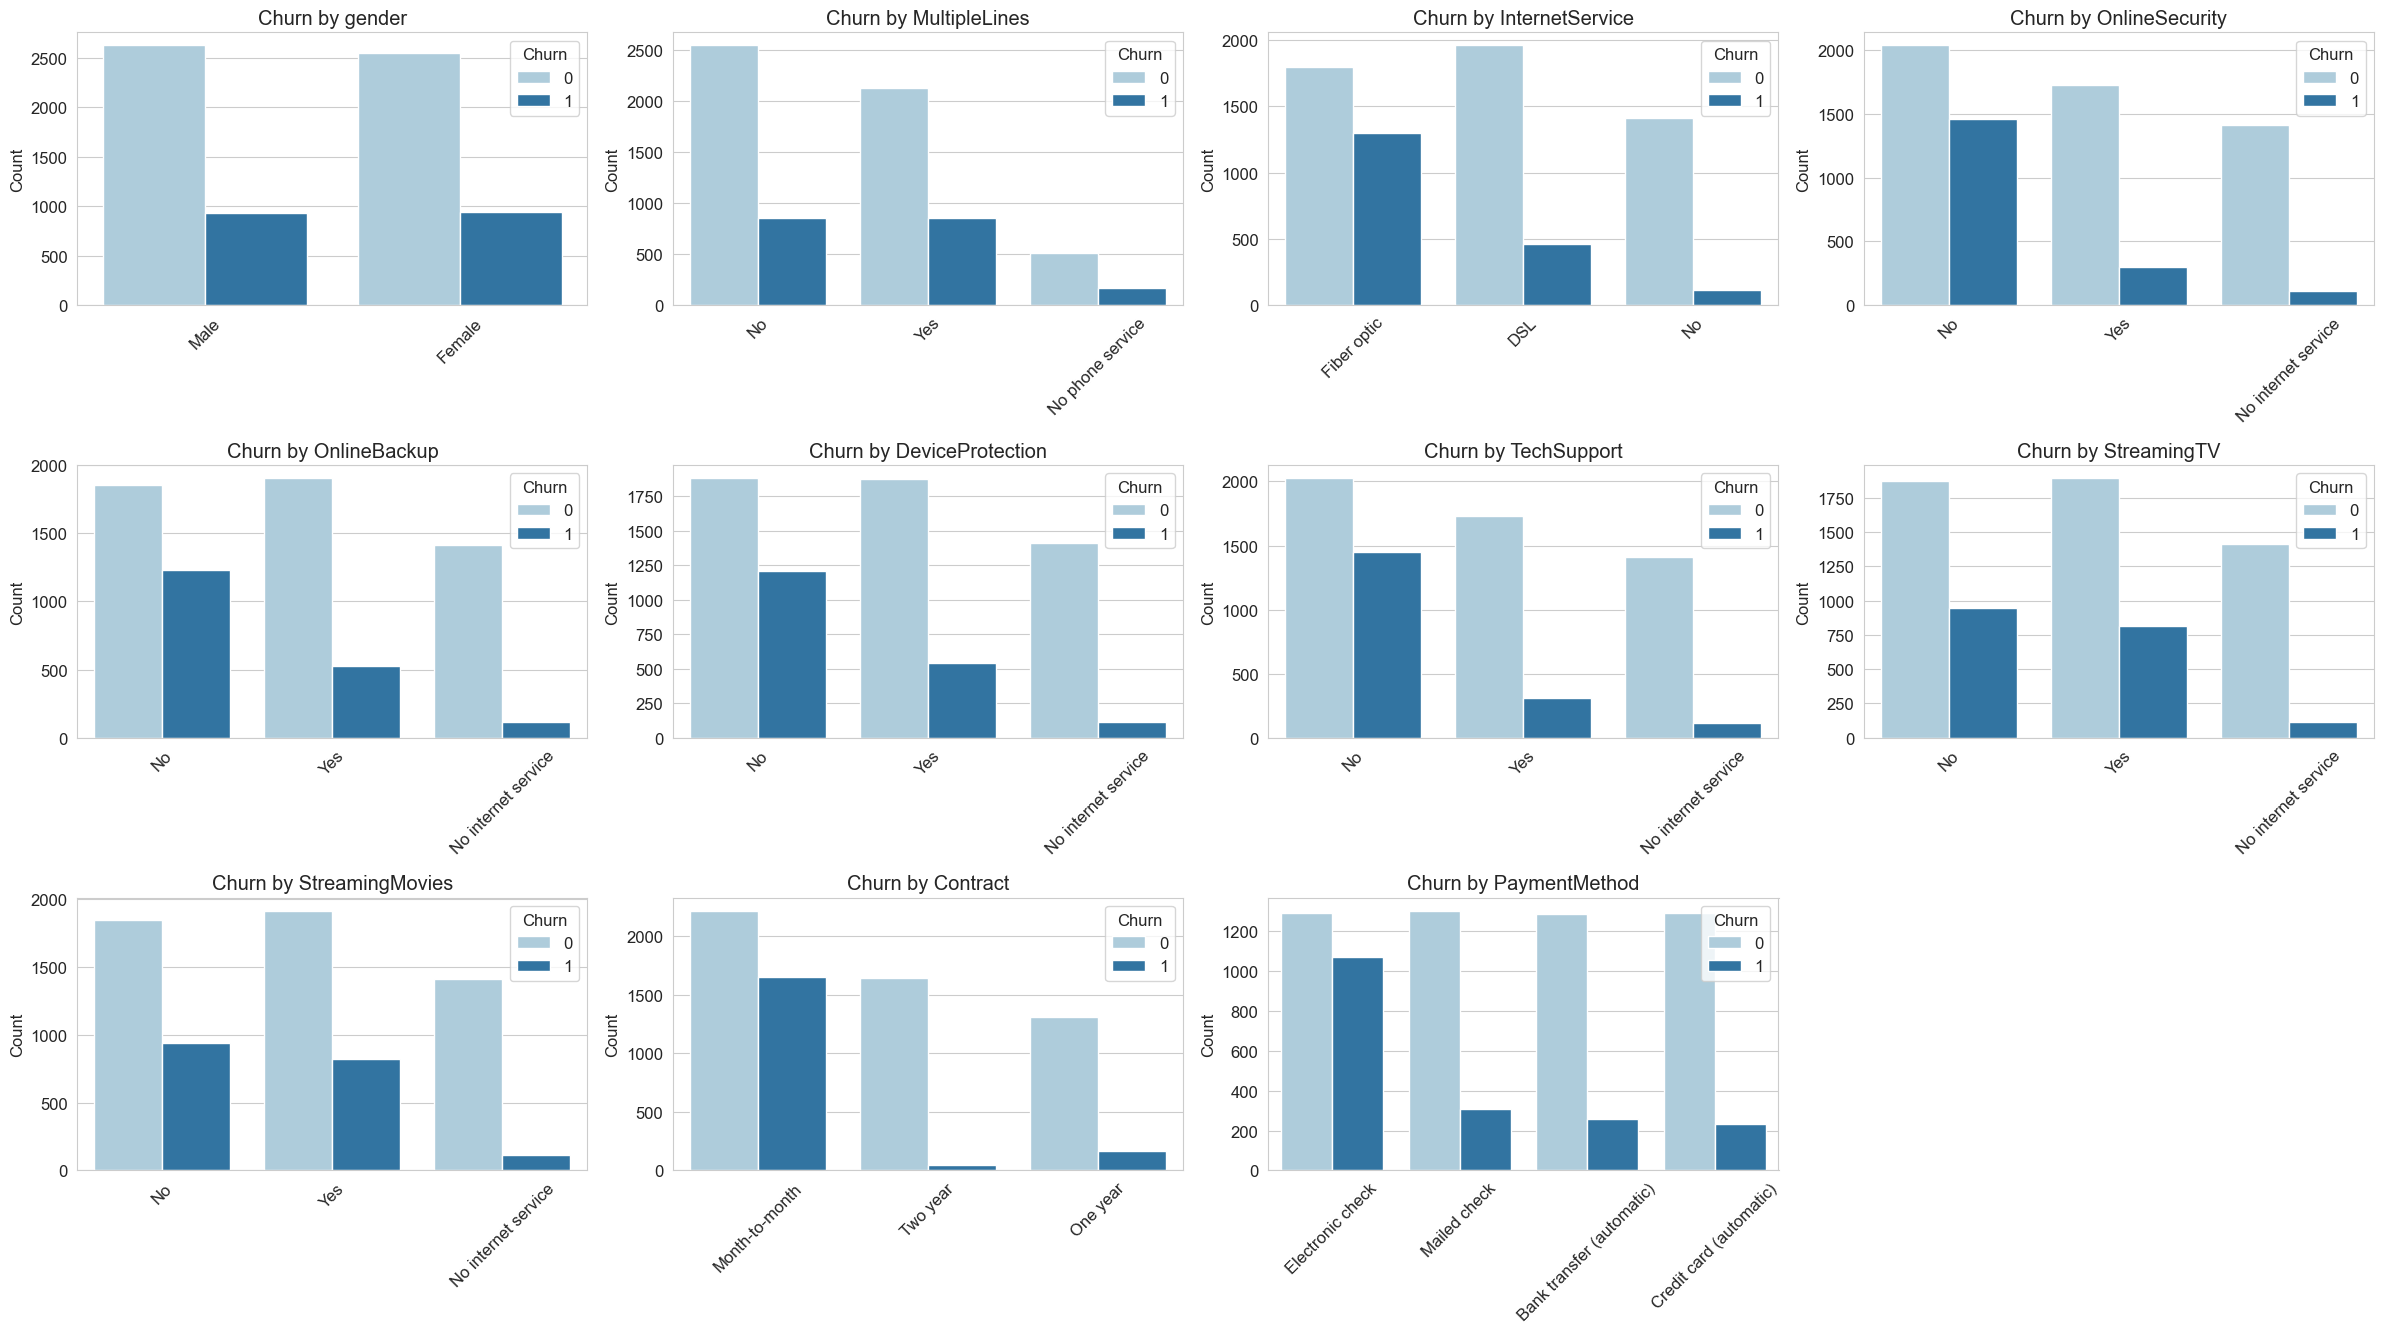

In [729]:
# 6.8 All categorical features vs Churn (stacked counts)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != "Churn"]

if cat_cols:
    n_cols = 4
    n_features = len(cat_cols)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        ax = axes[i]
        order = df[col].value_counts().index
        sns.countplot(
            data=df,
            x=col,
            hue="Churn",
            order=order,
            palette="Paired",
            ax=ax,
        )
        ax.set_title(f"Churn by {col}")
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


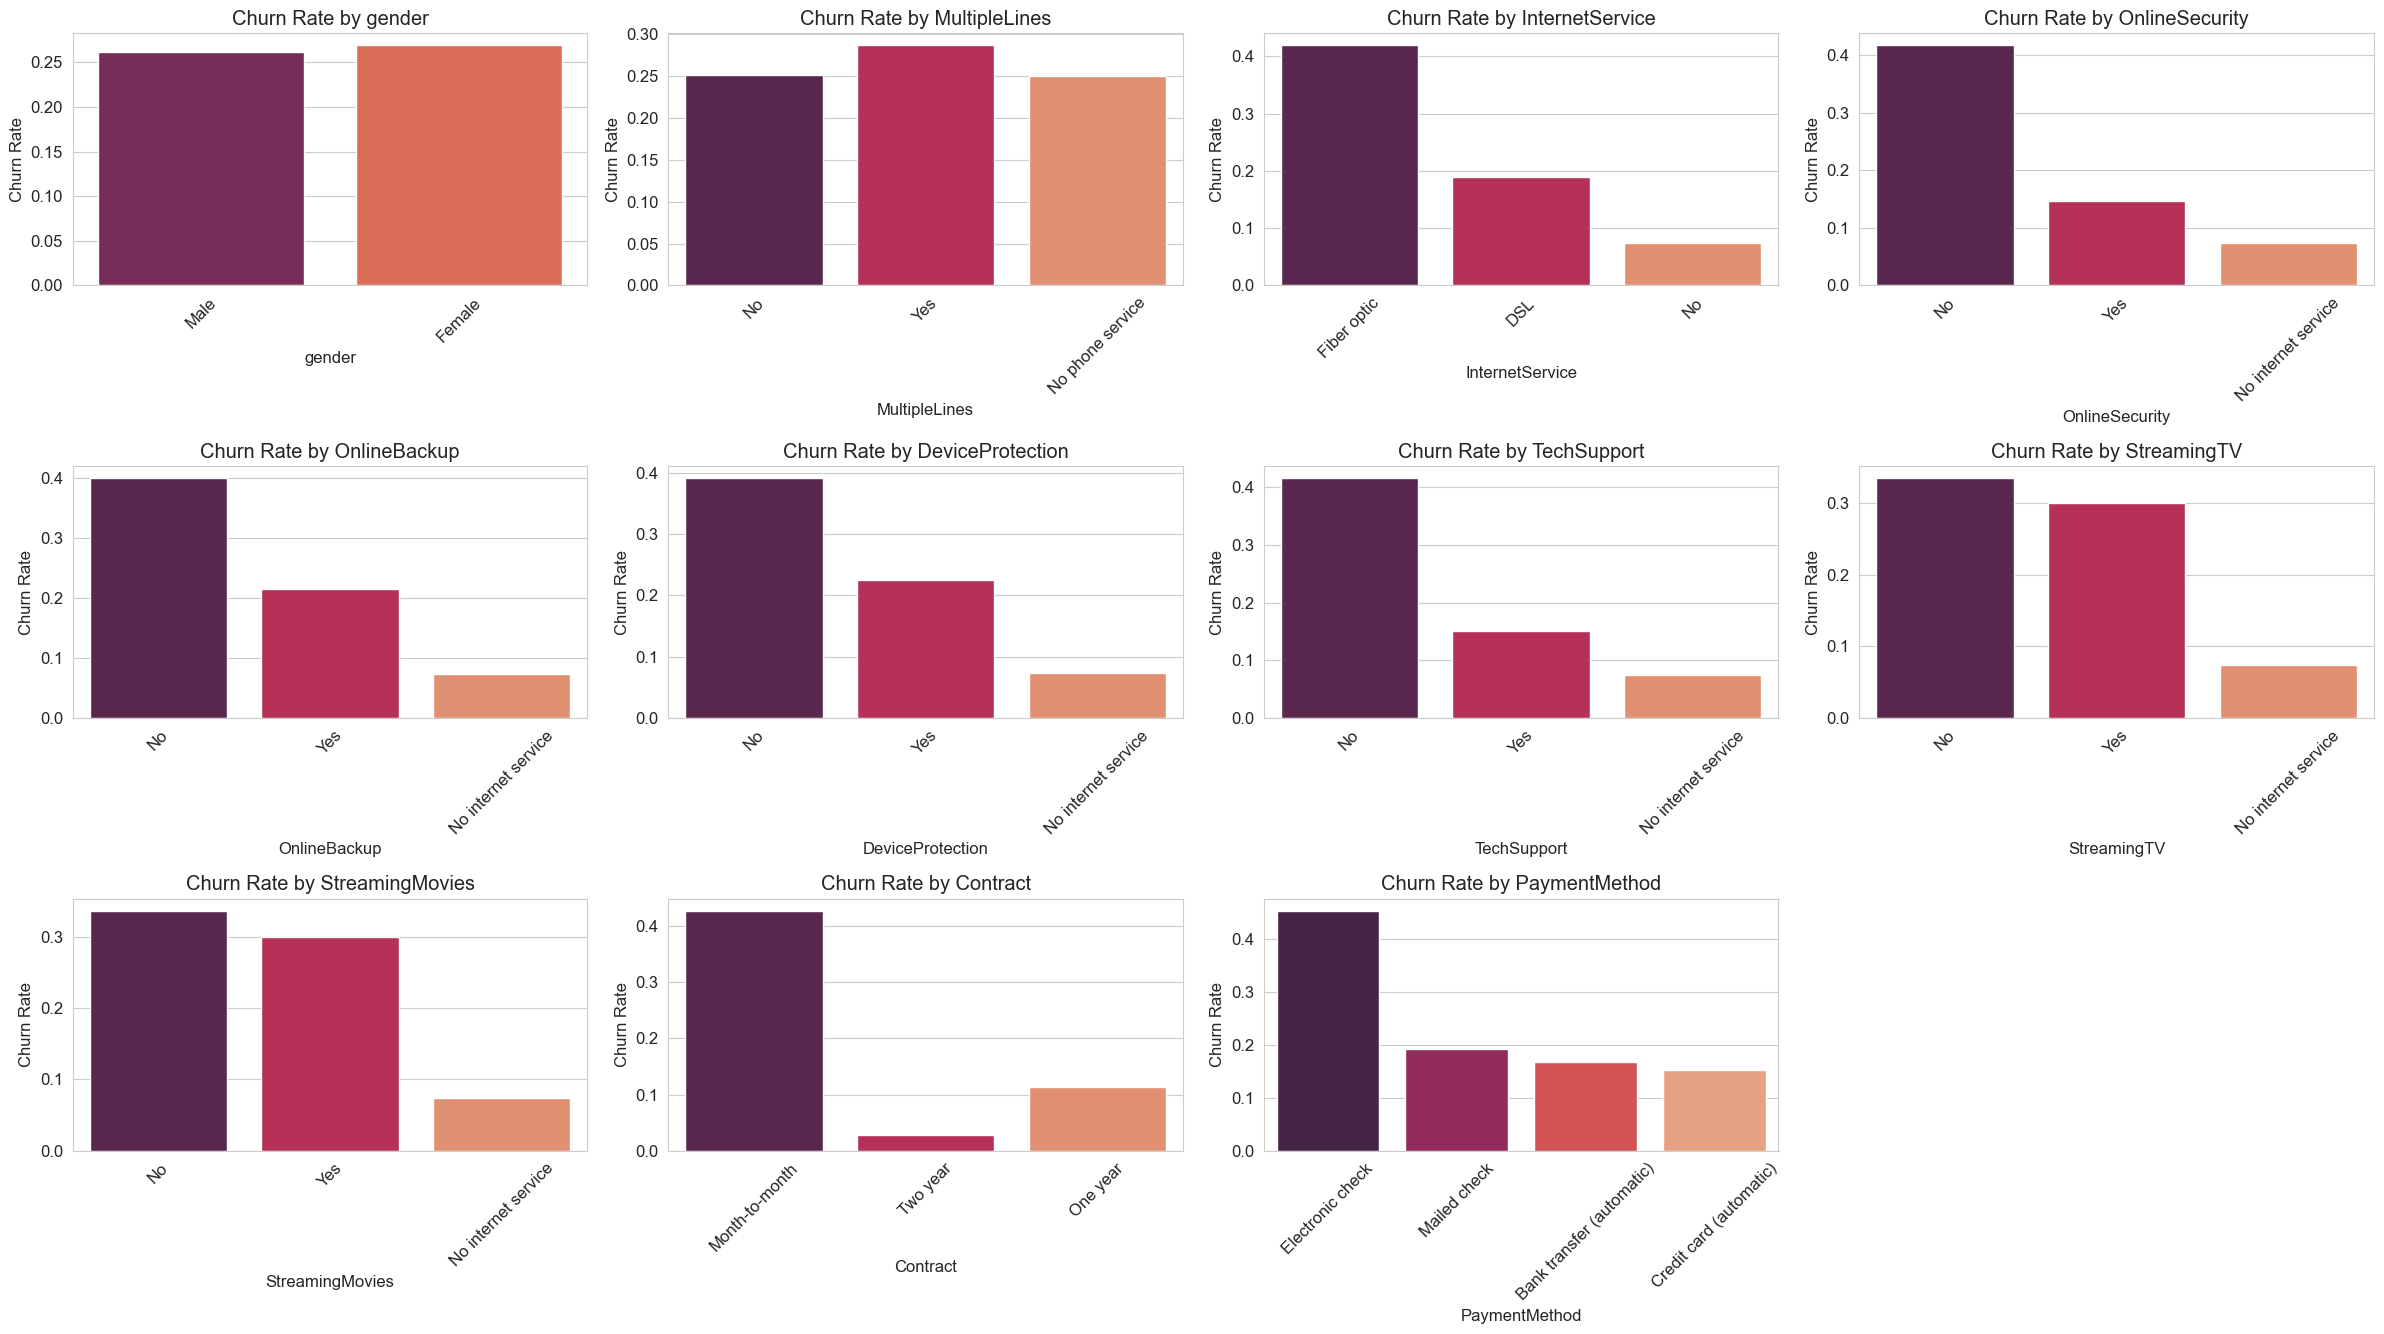

In [730]:
# Churn rate by category
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ["Churn", "customerID"]]

if not cat_cols:
    print("No categorical columns to plot churn rate for.")
else:
    n_cols = 4
    n_features = len(cat_cols)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
    axes = np.array(axes).flatten()

    for i, col in enumerate(cat_cols):
        rate = (
            df.groupby(col)["Churn"]
              .value_counts(normalize=True)
              .rename("proportion")
              .reset_index()
        )
        churn_rate = rate[rate["Churn"] == 1]

        ax = axes[i]
        sns.barplot(
            data=churn_rate,
            x=col,
            y="proportion",
            order=df[col].value_counts().index,
            palette="rocket",
            ax=ax,
        )
        ax.set_title(f"Churn Rate by {col}")
        ax.set_ylabel("Churn Rate")
        ax.set_xlabel(col)
        ax.tick_params(axis="x", rotation=45)

    # remove unused axes
    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


##### Multivariate analysis

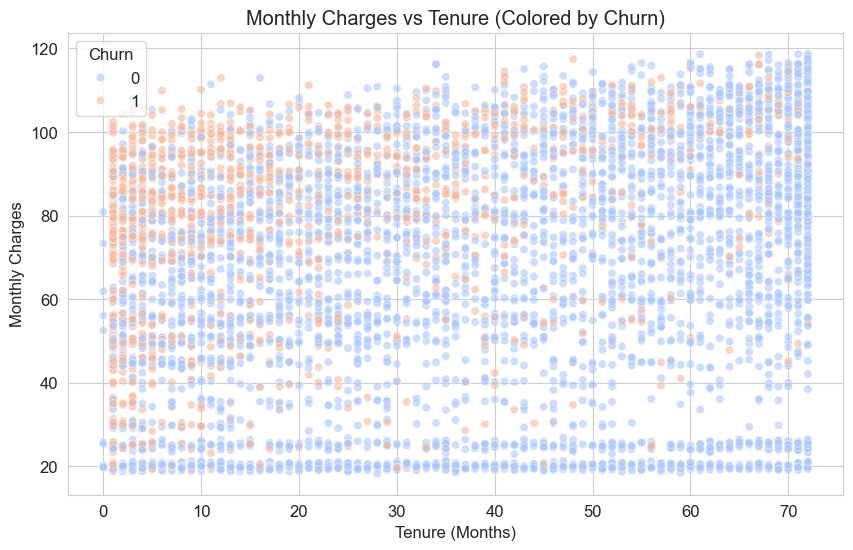

In [731]:
#  Tenure vs MonthlyCharges coloured by Churn

if {"tenure", "MonthlyCharges", "Churn"} <= set(df.columns):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="tenure",
        y="MonthlyCharges",
        hue="Churn",
        alpha=0.6,
        palette="coolwarm",
    )
    plt.title("Monthly Charges vs Tenure (Colored by Churn)")
    plt.xlabel("Tenure (Months)")
    plt.ylabel("Monthly Charges")
    plt.show()


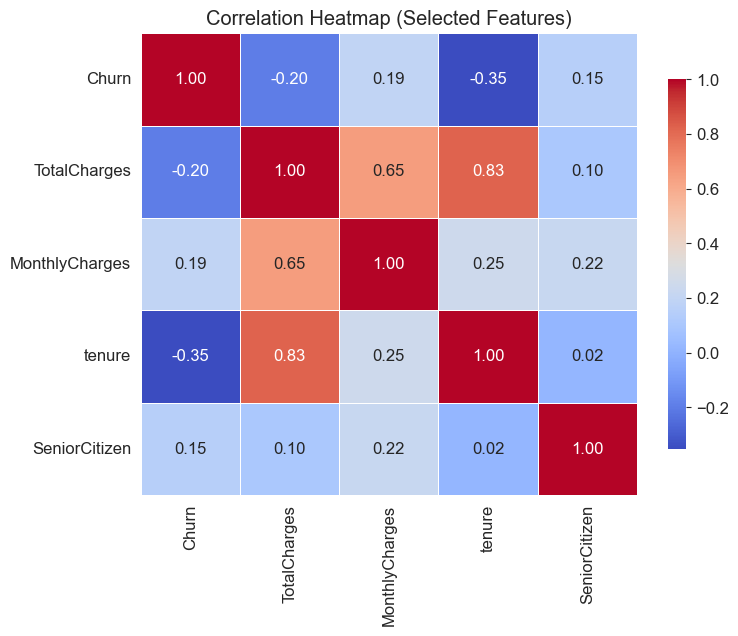

In [ ]:
# Select only the required columns
corr_cols = ["Churn", "TotalCharges", "MonthlyCharges", "tenure", "SeniorCitizen"]

# Filter dataframe for these columns only
corr_df = df[corr_cols]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap")
plt.show()


## 5. FEATURE ENGINEERING

In [733]:
# 5.1 Tenure bands
if "tenure" in df.columns:
    df["tenure_group"] = pd.cut(
        df["tenure"],
        bins=[-1, 12, 24, 48, 72, np.inf],
        labels=["0-12", "13-24", "25-48", "49-72", "73+"],
        include_lowest=True,
    )
    print("Added feature: tenure_group")

# 5.2 Charges per tenure (avoids division by zero)
if {"TotalCharges", "tenure"} <= set(df.columns):
    df["charges_per_tenure"] = df["TotalCharges"] / (df["tenure"] + 1)
    print("Added feature: charges_per_tenure")

# Helper: map service columns to 0/1 (Yes/1 -> 1, else 0)
def service_flag(v):
    if isinstance(v, (int, float)):
        return 1 if v == 1 else 0
    if isinstance(v, str):
        return 1 if v.strip().lower() == "yes" else 0
    return 0

# 5.3 Total number of subscribed services
service_cols = [
    "PhoneService",
    "MultipleLines",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

existing_service_cols = [c for c in service_cols if c in df.columns]

if existing_service_cols:
    svc_binary = df[existing_service_cols].applymap(service_flag)
    df["total_services"] = svc_binary.sum(axis=1)
    print("Added feature: total_services (count of subscribed services)")

# 5.4 Number of streaming services
streaming_cols = [c for c in ["StreamingTV", "StreamingMovies"] if c in df.columns]
if streaming_cols:
    streaming_binary = df[streaming_cols].applymap(service_flag)
    df["streaming_services"] = streaming_binary.sum(axis=1)
    print("Added feature: streaming_services")

# 5.5 Auto payment indicator
if "PaymentMethod" in df.columns:
    df["is_auto_pay"] = df["PaymentMethod"].str.contains(
        "automatic", case=False, na=False
    ).astype(int)
    print("Added feature: is_auto_pay")

print("\nFEATURE-ENGINEERED DATA (first 5 rows):")
display(df.head())


Added feature: tenure_group
Added feature: charges_per_tenure
Added feature: total_services (count of subscribed services)
Added feature: streaming_services
Added feature: is_auto_pay

FEATURE-ENGINEERED DATA (first 5 rows):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,charges_per_tenure,total_services,streaming_services,is_auto_pay
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,...,1,Electronic check,29.85,29.85,0,0-12,14.925000,1,0,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,...,0,Mailed check,56.95,1889.50,0,25-48,53.985714,3,0,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,...,1,Mailed check,53.85,108.15,1,0-12,36.050000,3,0,0
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,...,0,Bank transfer (automatic),42.30,1840.75,0,25-48,40.016304,3,0,1
4,Female,0,0,0,2,1,No,Fiber optic,No,No,...,1,Electronic check,70.70,151.65,1,0-12,50.550000,1,0,0


### 6. STATISTICAL TESTS 

In [734]:
# Chi-square tests for categorical features vs Churn
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != "Churn"]

chi2_results = []
for col in cat_cols:
    contingency = pd.crosstab(df[col], df["Churn"])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results.append({"feature": col, "p_value": p})

chi2_df = (
    pd.DataFrame(chi2_results)
      .sort_values("p_value")
      .reset_index(drop=True)
)

print("\nChi-square test p-values (categorical features vs Churn):")
display(chi2_df)


Chi-square test p-values (categorical features vs Churn):


,feature,p_value
0,Contract,5.863038e-258
1,OnlineSecurity,2.661150e-185
2,TechSupport,1.443084e-180
3,InternetService,9.571788e-160
4,PaymentMethod,3.682355e-140
5,OnlineBackup,2.079759e-131
6,DeviceProtection,5.505219e-122
7,StreamingMovies,2.667757e-82
8,StreamingTV,5.528994e-82
9,MultipleLines,3.464383e-03


In [735]:
# T-tests for numeric features vs Churn
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["Churn"]]

ttest_results = []
churn_yes = df[df["Churn"] == 1]
churn_no = df[df["Churn"] == 0]

for col in numeric_cols:
    t_stat, p = ttest_ind(churn_yes[col], churn_no[col], equal_var=False)
    ttest_results.append({"feature": col, "p_value": p})

ttest_df = pd.DataFrame(ttest_results).sort_values("p_value")

print("\nT-test p-values (numeric features vs Churn):")
display(ttest_df)


T-test p-values (numeric features vs Churn):


,feature,p_value
3,tenure,1.195495e-232
11,is_auto_pay,7.452631e-78
7,TotalCharges,2.059075e-75
6,MonthlyCharges,8.592449e-73
5,PaperlessBilling,4.802979e-66
2,Dependents,9.878649e-53
1,Partner,7.980266e-38
0,SeniorCitizen,3.587587e-29
9,total_services,5.313758e-10
10,streaming_services,2.330828e-09


### 7. SAVE PREPROCESSED DATASET

In [736]:
os.makedirs("preprocessed_dataset", exist_ok=True)
output_path = "preprocessed_dataset/preprocessed_data.csv"
df.to_csv(output_path, index=False)

print("\nPreprocessing complete!")
print(f"Saved cleaned + feature-engineered dataset to:\n{output_path}")


Preprocessing complete!
Saved cleaned + feature-engineered dataset to:
preprocessed_dataset/preprocessed_data.csv
